---

### Homework Assignment: Comprehensive Exploration of CNN Techniques

#### Objective:

The objective of this assignment is to explore various techniques used in convolutional neural networks (CNNs) for image classification tasks. Specifically, students will experiment with different regularization techniques and initialization methods to understand their impact on model performance.

#### Tasks:

1. **Dataset Preparation:**

   - Download the CIFAR-10 dataset, a widely used benchmark dataset for image classification.
   - Preprocess the dataset by normalizing the pixel values and splitting it into training and testing sets.

2. **Experiment 1: Regularization Techniques:**

   - Implement a CNN model architecture for image classification using PyTorch.
   - Experiment with different regularization techniques:
     - No regularization
     - L2 regularization
     - Dropout regularization
   - Train each model using the training set and evaluate its performance on the testing set.
   - Compare and analyze the impact of each regularization technique on model performance.

3. **Experiment 2: Initialization Techniques:**

   - Implement a CNN model architecture for image classification using PyTorch.
   - Experiment with different weight initialization techniques:
     - Default initialization
     - Xavier initialization
     - Kaiming initialization
   - Train each model using the training set and evaluate its performance on the testing set.
   - Compare and analyze the impact of each initialization technique on model performance.

4. **Experiment 3: Learning Rate Scheduling:**

   - Experiment with different techniques:
     - Step decay
     - Exponential decay
     - Cyclic learning rates
   - Train each model using the training set and evaluate its performance on the testing set.
   - Compare and analyze the impact of each initialization technique on model performance.

5. **Analysis and Conclusion:**
   - Analyze the results obtained from the experiments conducted in Steps 2 and 3,4.
   - Discuss the strengths and weaknesses of each regularization technique and initialization method.
   - Provide insights into how these techniques affect model performance, training convergence, and generalization ability.
   - Propose recommendations for selecting appropriate techniques based on the characteristics of the dataset and task.

#### Submission Guidelines:

- Students are required to submit a Jupyter Notebook containing the implementation of the CNN models with various techniques, along with necessary explanations, comments, and visualizations.
- Additionally, students must provide a detailed report summarizing their findings, including comparisons of model performance, analysis of techniques, and insights gained from the experimentation.


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

## 1. Dataset Preperation


In [21]:
batch_size = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


## 2. Experiment 1


### Model 1 No Reg


In [22]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = self.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = self.relu(self.conv3(x))
        x = self.maxpool3(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def train_model(self, optimizer, crit, train_loader, test_loader, num_epochs, device, scheduler=None):
        history = {'train_loss': [], 'val_loss': [],
                   'val_accuracy': [], 'train_step_loss': [],
                   'val_step_loss': []}
        total_step = len(train_loader)

        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                outputs = self(images)
                loss = crit(outputs, labels)
                train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 100 == 0:
                    print(
                        f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Train Loss: {loss.item():.4f}')
                    history['train_step_loss'].append(loss.item())

            avg_train_loss = train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            print(
                f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}')

            if scheduler:
                scheduler.step()

            val_loss, val_accuracy = self.evaluate(
                test_loader, crit, device, history)  # Pass history to evaluate
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            print(
                f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        return history

    # Add history parameter with default None
    def evaluate(self, test_loader, crit, device, history=None):
        self.eval()
        correct, total, val_loss = 0, 0, 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                loss = crit(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if (i + 1) % 100 == 0 and history is not None:
                    history['val_step_loss'].append(loss.item())
        avg_val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total

        print('==================================================================')
        print(f'Test Loss: {avg_val_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

        return avg_val_loss, accuracy

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
model_baseline = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_baseline.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
baseline_history = model_baseline.train_model(
    optimizer, criterion, train_loader, test_loader, 2, device, scheduler)

Epoch [1/2], Step [100/782], Train Loss: 1.8018
Epoch [1/2], Step [200/782], Train Loss: 1.3771
Epoch [1/2], Step [300/782], Train Loss: 1.2454
Epoch [1/2], Step [400/782], Train Loss: 1.2045
Epoch [1/2], Step [500/782], Train Loss: 0.9956
Epoch [1/2], Step [600/782], Train Loss: 1.4324
Epoch [1/2], Step [700/782], Train Loss: 0.9323
Epoch 1/2: Train Loss: 1.3894
Test Loss: 1.0915, Test Accuracy: 60.79%
Epoch [1/2], Val Loss: 1.0915, Val Accuracy: 60.79%
Epoch [2/2], Step [100/782], Train Loss: 0.9613
Epoch [2/2], Step [200/782], Train Loss: 0.9647
Epoch [2/2], Step [300/782], Train Loss: 1.2413
Epoch [2/2], Step [400/782], Train Loss: 1.0697
Epoch [2/2], Step [500/782], Train Loss: 1.1491
Epoch [2/2], Step [600/782], Train Loss: 1.0620
Epoch [2/2], Step [700/782], Train Loss: 1.1730
Epoch 2/2: Train Loss: 0.9828
Test Loss: 0.9306, Test Accuracy: 67.91%
Epoch [2/2], Val Loss: 0.9306, Val Accuracy: 67.91%


### Model 2 L2


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
model_l2 = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_l2.parameters(),
                       lr=learning_rate, weight_decay=.003)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
l2_history = model_l2.train_model(
    optimizer, criterion, train_loader, test_loader, 2, device, scheduler)

Epoch [1/2], Step [100/782], Train Loss: 1.5815
Epoch [1/2], Step [200/782], Train Loss: 1.4854
Epoch [1/2], Step [300/782], Train Loss: 1.4459
Epoch [1/2], Step [400/782], Train Loss: 1.0606
Epoch [1/2], Step [500/782], Train Loss: 1.1509
Epoch [1/2], Step [600/782], Train Loss: 0.9572
Epoch [1/2], Step [700/782], Train Loss: 1.2003
Epoch 1/2: Train Loss: 1.3728
Test Loss: 1.1674, Test Accuracy: 59.38%
Epoch [1/2], Val Loss: 1.1674, Val Accuracy: 59.38%
Epoch [2/2], Step [100/782], Train Loss: 0.9883
Epoch [2/2], Step [200/782], Train Loss: 1.2081
Epoch [2/2], Step [300/782], Train Loss: 1.0920
Epoch [2/2], Step [400/782], Train Loss: 0.8898
Epoch [2/2], Step [500/782], Train Loss: 1.1060
Epoch [2/2], Step [600/782], Train Loss: 0.9538
Epoch [2/2], Step [700/782], Train Loss: 1.0984
Epoch 2/2: Train Loss: 1.0137
Test Loss: 1.0282, Test Accuracy: 63.81%
Epoch [2/2], Val Loss: 1.0282, Val Accuracy: 63.81%


### Model 3 Dropout


In [ ]:
class CNN_Dropout(nn.Module):
    def __init__(self):
        super(CNN_Dropout, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.Dropout2d(.3),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * 4 * 4, 512),
            nn.Dropout(.3),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.layers(x)
        return x

    def train_model(self, optimizer, crit, train_loader, test_loader, num_epochs, device, scheduler=None):
        history = {'train_loss': [], 'val_loss': [],
                   'val_accuracy': [], 'train_step_loss': [],
                   'val_step_loss': []}
        total_step = len(train_loader)

        for epoch in range(num_epochs):
            self.train()
            train_loss = 0
            for i, (images, labels) in enumerate(train_loader):
                images, labels = images.to(device), labels.to(device)

                outputs = self(images)
                loss = crit(outputs, labels)
                train_loss += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 100 == 0:
                    print(
                        f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Train Loss: {loss.item():.4f}')
                    history['train_step_loss'].append(loss.item())

            avg_train_loss = train_loss / len(train_loader)
            history['train_loss'].append(avg_train_loss)
            print(
                f'Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}')

            if scheduler:
                scheduler.step()

            val_loss, val_accuracy = self.evaluate(
                test_loader, crit, device, history)  # Pass history to evaluate
            history['val_loss'].append(val_loss)
            history['val_accuracy'].append(val_accuracy)

            print(
                f'Epoch [{epoch+1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

        return history

    # Add history parameter with default None
    def evaluate(self, test_loader, crit, device, history=None):
        self.eval()
        correct, total, val_loss = 0, 0, 0

        with torch.no_grad():
            for i, (images, labels) in enumerate(test_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = self(images)
                loss = crit(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if (i + 1) % 100 == 0 and history is not None:
                    history['val_step_loss'].append(loss.item())
        avg_val_loss = val_loss / len(test_loader)
        accuracy = 100 * correct / total

        print('==================================================================')
        print(f'Test Loss: {avg_val_loss:.4f}, Test Accuracy: {accuracy:.2f}%')

        return avg_val_loss, accuracy

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 64
learning_rate = 0.001
model_dropout = CNN_Dropout()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(),
                       lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
dropout_history = model_dropout.train_model(
    optimizer, criterion, train_loader, test_loader, 2, device, scheduler)

Epoch [1/2], Step [100/782], Train Loss: 1.6627
Epoch [1/2], Step [200/782], Train Loss: 1.5534
Epoch [1/2], Step [300/782], Train Loss: 1.4703
Epoch [1/2], Step [400/782], Train Loss: 1.4254
Epoch [1/2], Step [500/782], Train Loss: 1.5599
Epoch [1/2], Step [600/782], Train Loss: 1.3255
Epoch [1/2], Step [700/782], Train Loss: 1.2580
Epoch 1/2: Train Loss: 1.4659
Test Loss: 1.1329, Test Accuracy: 60.34%
Epoch [1/2], Val Loss: 1.1329, Val Accuracy: 60.34%
Epoch [2/2], Step [100/782], Train Loss: 1.4580
Epoch [2/2], Step [200/782], Train Loss: 1.4760
Epoch [2/2], Step [300/782], Train Loss: 0.8505
Epoch [2/2], Step [400/782], Train Loss: 1.1589
Epoch [2/2], Step [500/782], Train Loss: 1.4747
Epoch [2/2], Step [600/782], Train Loss: 1.1496
Epoch [2/2], Step [700/782], Train Loss: 1.3470
Epoch 2/2: Train Loss: 1.1880
Test Loss: 1.0034, Test Accuracy: 65.43%
Epoch [2/2], Val Loss: 1.0034, Val Accuracy: 65.43%


In [27]:
import matplotlib.pyplot as plt


def plot_histories(histories, labels):
    metrics = ['train_loss', 'val_loss', 'val_accuracy',
               'train_step_loss', 'val_step_loss']
    titles = ['Train Loss', 'Validation Loss', 'Validation Accuracy',
              'Train Step Loss', 'Validation Step Loss']
    fig, axes = plt.subplots(1, len(metrics), figsize=(20, 4))

    for idx, metric in enumerate(metrics):
        for history, label in zip(histories, labels):
            axes[idx].plot(history[metric], label=label)
        axes[idx].set_title(titles[idx])
        axes[idx].set_xlabel('Epoch')
        axes[idx].legend()
        axes[idx].grid(True)

    plt.tight_layout()
    plt.show()

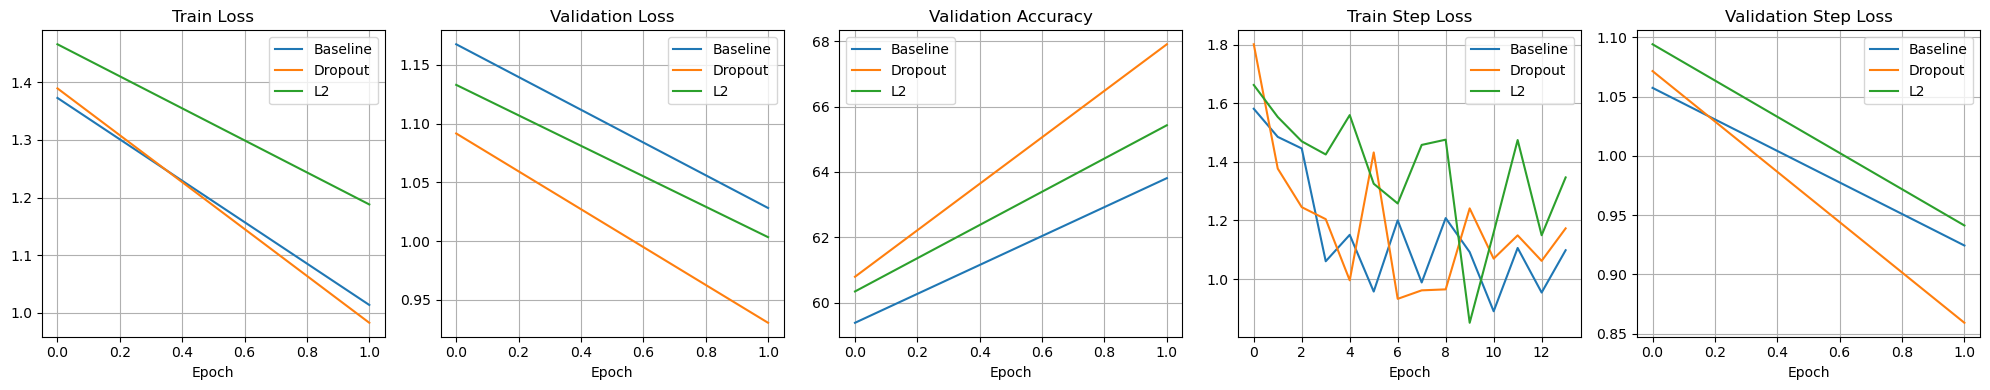

In [28]:
plot_histories([l2_history, baseline_history, dropout_history],
               ['Baseline', 'Dropout', 'L2'])

# Example for using various regulization techniques


In [29]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torchvision
# import torchvision.transforms as transforms

# # Device configuration
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Hyperparameters
# num_epochs = 1
# batch_size = 64
# learning_rate = 0.001

# # Dataset
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# train_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=True, transform=transform, download=True)
# test_dataset = torchvision.datasets.CIFAR10(
#     root='./data', train=False, transform=transform)

# train_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     dataset=test_dataset, batch_size=batch_size, shuffle=False)

# # Model


# class CNN(nn.Module):
#     def __init__(self):
#         super(CNN, self).__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
#         self.fc1 = nn.Linear(64 * 8 * 8, 512)
#         self.fc2 = nn.Linear(512, 10)
#         self.relu = nn.ReLU()
#         self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = self.conv2(x)
#         x = self.relu(x)
#         x = self.maxpool(x)
#         x = x.view(-1, 64 * 8 * 8)
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x


# # Experiment 1: Regularization Techniques
# regularization_methods = {
#     "No Regularization": None,
#     "L2 Regularization": 1e-4
#     # Add more regularization techniques as needed
# }

# print("Experiment 1: Regularization Techniques")
# for name, regularization in regularization_methods.items():
#     print(f"Experimenting with {name}")
#     model = CNN().to(device)

#     # Loss and optimizer
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#     if regularization is not None:
#         # Apply regularization to the optimizer
#         optimizer = optim.Adam(
#             model.parameters(), lr=learning_rate, weight_decay=regularization)

#     # Training loop
#     for epoch in range(num_epochs):
#         model.train()
#         for i, (images, labels) in enumerate(train_loader):
#             images = images.to(device)
#             labels = labels.to(device)

#             # Forward pass
#             outputs = model(images)
#             loss = criterion(outputs, labels)

#             # Backward and optimize
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             if (i+1) % 100 == 0:
#                 print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
#                       .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

#     # Test the model
#     model.eval()
#     with torch.no_grad():
#         correct = 0
#         total = 0
#         for images, labels in test_loader:
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()

#         accuracy = 100 * correct / total
#         print(f'Accuracy of the model on the test images: {accuracy}%')
#     print()

# Some functions you need to learn, read about and experiment with :


In [30]:
# # Default Initialization
# nn.init.normal_(self.conv1.weight)
# nn.init.normal_(self.conv2.weight)
# nn.init.normal_(self.fc1.weight)
# nn.init.normal_(self.fc2.weight)

# # Xavier Initialization
# nn.init.xavier_normal_(self.conv1.weight)
# nn.init.xavier_normal_(self.conv2.weight)
# nn.init.xavier_normal_(self.fc1.weight)
# nn.init.xavier_normal_(self.fc2.weight)

# # Kaiming Initialization
# nn.init.kaiming_normal_(self.conv1.weight)
# nn.init.kaiming_normal_(self.conv2.weight)
# nn.init.kaiming_normal_(self.fc1.weight)
# nn.init.kaiming_normal_(self.fc2.weight)

In [31]:
# # Adam Optimizer
# optimizer_adam = optim.Adam(model.parameters(), lr=learning_rate)

# # SGD Optimizer
# optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

# # RMSprop Optimizer
# optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate)